### Data Description ###

Our chosen dataset, the *players.csv* file, has a total of 196 observations. These observations include players':
- Experience level (chr)
   - (Beginner, Amateur, Regular, Pro, and Veteran)
- Subscription status (lgl)
- Played hours (dbl)
- Name (chr)
- Gender (chr)
- Age (int)
- Email hash code (chr)
   - Unique player identifier

for a total of 7 variables.

The players have an average played hours of 5.85 and age of 20.52. The distribution of experience is as follows:

- Beginner: 17.86%
- Amateur: 32.14%
- Regular: 18.37%
- Pro: 7.14%
- Veteran: 24.49%

73.47% of players subscribe to the newsletter.

 A key issue is that 74% of players have played 0.5 hours or less, heavily skewing the data and impacting predictions based on *played_hours*. There is also uncertainty in self-reported experience levels, as classification lacks a defined benchmark.

### Questions ###

Our broad question: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

Our specific question: Does played hours or age most accurately predict a player's subscription status in *players.csv*?

To classify effectively using knn, we will remove missing data and standardize *age* and played_hours.

### Data Analysis & Visualization ###

In [22]:
library(tidyverse)
library(repr)
library(readxl)
library(janitor)
library(gridExtra)
options(repr.matrix.max.rows = 7, repr.plot.height = 6, repr.plot.width = 16)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


avg_hours,avg_age
<dbl>,<dbl>
5.85,20.52


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


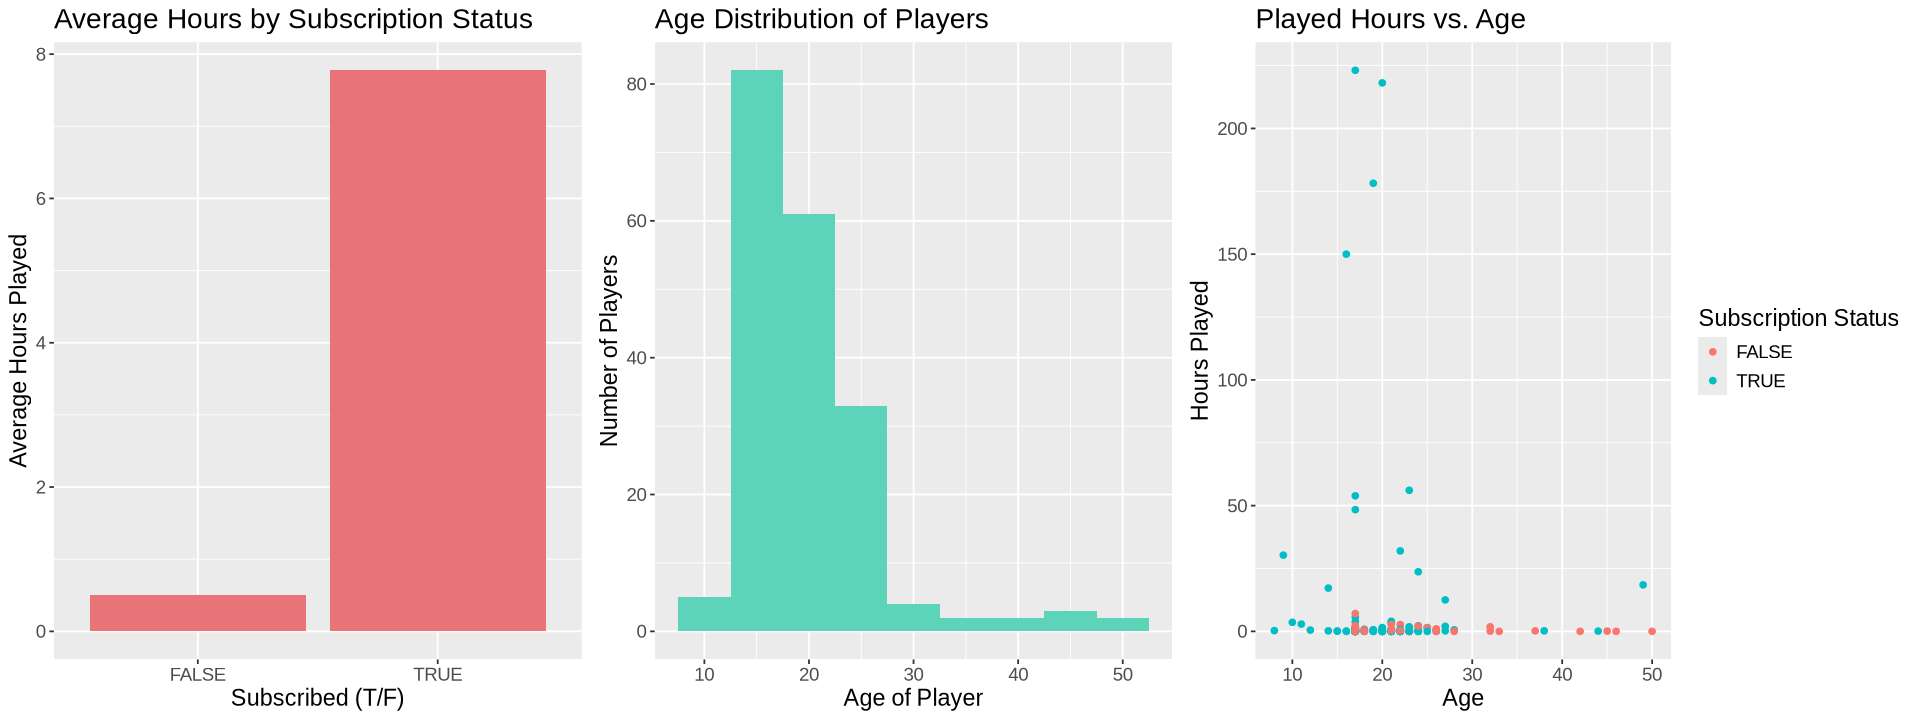

In [30]:
url <- 'https://raw.githubusercontent.com/justin-pilson/project_plan_individual/refs/heads/main/players.csv'

players <- read_csv(url) |>
    clean_names() |>
    mutate(experience = as_factor(experience)) |>
    mutate(age = as.integer(age))

avg_played_hours <- players |>
    summarize(avg_hours = mean(played_hours)) |>
    pull()

avg_age <- players |>
    summarize(avg_age = mean(age, na.rm = TRUE)) |>
    pull()

averages <- tibble(avg_hours = round(avg_played_hours, 2), avg_age = round(avg_age, 2))

averages

avg_hours_plot <- players |>
    group_by(subscribe) |>
    summarize(avg_hours = mean(played_hours)) |>
    mutate(subscribe = as_factor(subscribe)) |>
    ggplot(aes(x = subscribe, y = avg_hours)) +
        geom_bar(stat = "identity", fill = '#e87478') +  
        labs(title = 'Average Hours by Subscription Status', 
             x = 'Subscribed (T/F)', 
             y = 'Average Hours Played') +
        theme(text = element_text(size = 14))

age_histogram <- players |>
    ggplot(aes(x = age)) +
    geom_histogram(binwidth = 5, fill = '#5dd4ba') +
    labs(x = 'Age of Player', y = 'Number of Players', title = 'Age Distribution of Players') +
    theme(text = element_text(size = 14))

age_vs_hours_plot <- players |>
    ggplot(aes(x = age, y = played_hours, colour = subscribe)) +
        geom_point() +
        labs(x = 'Age',
             y = 'Hours Played',
             colour = 'Subscription Status',
             title = 'Played Hours vs. Age') +
             theme(text = element_text(size = 14))

grid.arrange(avg_hours_plot, 
             age_histogram, 
             age_vs_hours_plot, 
             ncol = 3, widths = c(4, 4, 5))

There is a correlation between subscription status and average hours played, with those who are subscribed having a higher average hours played. There also appears to be a slight correlation between age and subscription, as a majority of subscribed individuals are below the age of 30. Lastly, the bulk of individuals are below the age of 25.

### Methods and Plan ###

Our plan is to use our different predictor variables separately to attempt to classify subscription status, and then analyze the accuracy and recall of each one to come up with an answer to our broad question.

Why is this method appropriate?

- It allows us to directly compare our variables to determine which predicts our variable of interest most accurately, allowing us to miss as few *subscribed* classifications as possible

Which assumptions are required, if any, to apply the method selected?

- We assume that this dataset accurately represents the individuals that will be using the server moving forward

What are the potential limitations or weaknesses of the method selected?

- By choosing just two variables to compare, we will potentially miss out on a relationship between experience level and subscription status, for example

How are you going to compare and select the model?

- By comparing the accuracies and recall, using the metrics() function to analyze *played_hours* and *age*

How are you going to process the data to apply the model?

- Split the data into training and testing, with a 75/25 split
- Standardize the data, as knn uses distance to classify variables
- Split our training data into 5 folds for cross-validation
- Use accuracy and recall to determine the best k value, selecting the one with the highest combination of both
- Apply our fitted model to the test data, using recall and accuracy to pick the variable that most effectively predicts subscription status